## 1.Prepare the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --upgrade redner-gpu

In [ ]:
import pyredner
import torch
import redner
import matplotlib.pyplot as plt

In [ ]:
%cd drive/MyDrive/BigDataHub/Differentiable_Render/
!ls

In [ ]:
# load DC3 Model
material_map, mesh_list, light_map = pyredner.load_obj('./DC3_model/dc3.obj')
objects = pyredner.load_obj('./DC3_model/dc3.obj', return_objects=True)

In [ ]:
#visualize meshes
print(material_map.keys())
print(mesh_list)
print(mesh_list[0][1])
print(torch.max(mesh_list[0][1].vertices))
print(len(mesh_list[0][1].vertices))
print(len(mesh_list[0][1].indices))
print(len(mesh_list[0][1].uvs))
print(len(mesh_list[0][1].uv_indices))
#the center of airplane vertices
center = torch.mean(mesh_list[0][1].vertices, 0)
print("center of airplane", center)

dict_keys(['housing', 'aerials', 'handle', 'engines', 'lightbulbs', 'lightbulb_red', 'levers', 'floor', 'seat', 'sides', 'cabin', 'glass_orange', 'reflectors', 'glass', 'chassis', 'chassis_damper_stock', 'wheels', 'chassis_rims', 'chassis_tubes', 'propellers', 'caps', 'steering_wheel', 'exhaust'])
[('housing', <pyredner.load_obj.TriangleMesh object at 0x7f0782db8250>), ('aerials', <pyredner.load_obj.TriangleMesh object at 0x7f078125fc10>), ('handle', <pyredner.load_obj.TriangleMesh object at 0x7f0782db4710>), ('engines', <pyredner.load_obj.TriangleMesh object at 0x7f0782d9f250>), ('lightbulbs', <pyredner.load_obj.TriangleMesh object at 0x7f077d7d2cd0>), ('lightbulb_red', <pyredner.load_obj.TriangleMesh object at 0x7f077d842550>), ('levers', <pyredner.load_obj.TriangleMesh object at 0x7f077d8428d0>), ('floor', <pyredner.load_obj.TriangleMesh object at 0x7f077d842b50>), ('seat', <pyredner.load_obj.TriangleMesh object at 0x7f077d842a90>), ('sides', <pyredner.load_obj.TriangleMesh object a

## 2 Construct the Scene

In [ ]:
#  compute the normals of mesh
for _, mesh in mesh_list:
    mesh.normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)

# Setup materials
material_id_map = {}
materials = []
count = 0
for key, value in material_map.items():
    material_id_map[key] = count
    count += 1
    materials.append(value)
print(material_id_map)

# Setup geometries
shapes = []
for mtl_name, mesh in mesh_list:
    shapes.append(pyredner.Shape(\
        #vertices = mesh.vertices /100.0,
        vertices = mesh.vertices,
        indices = mesh.indices,
        uvs = mesh.uvs ,
        normals = mesh.normals,
        material_id = material_id_map[mtl_name]))

{'housing': 0, 'aerials': 1, 'handle': 2, 'engines': 3, 'lightbulbs': 4, 'lightbulb_red': 5, 'levers': 6, 'floor': 7, 'seat': 8, 'sides': 9, 'cabin': 10, 'glass_orange': 11, 'reflectors': 12, 'glass': 13, 'chassis': 14, 'chassis_damper_stock': 15, 'wheels': 16, 'chassis_rims': 17, 'chassis_tubes': 18, 'propellers': 19, 'caps': 20, 'steering_wheel': 21, 'exhaust': 22}


In [ ]:
# # Setup camera for airplane
# # Setup camera
cam = pyredner.Camera(position = torch.tensor([12.0, -5.0, 7.0]),   #teapot - [0.0, 30.0, 2000.0]
                      look_at = torch.tensor([0.0, -0.0, 0.0]),
                      up = torch.tensor([0.0, 0.1, 0.0]),               # teapot  - [0.0, 0.1, 0.0]
                      fov = torch.tensor([45.0]), # in degree
                      clip_near = 1e-2, # needs to > 0
                      resolution = (256, 256),
                      fisheye = False)

#cam = pyredner.automatic_camera_placement(objects, resolution=(512, 512))

In [ ]:
envmap = pyredner.imread('./DC3_model/sunsky.exr')
if pyredner.get_use_gpu():
    envmap = envmap.cuda(device = pyredner.get_device())
envmap = pyredner.EnvironmentMap(envmap)

In [ ]:
## assign a target pos
cp = [-10.0, -2.0, 13.0]
lk = [0.0, -0.0,  0.0]
u = [.0, 1.0, 0.0]

cam.position = torch.tensor(cp)
cam.look_at = torch.tensor(lk)
cam.resolution = (256,455)

In [ ]:
# We don't setup any light source here

# Construct the scene
scene = pyredner.Scene(cam, shapes, materials, area_lights = [], envmap = None)
# Serialize the scene
# Here we specify the output channels as "depth", "shading_normal"
scene_args = pyredner.RenderFunction.serialize_scene(\
    scene = scene,
    num_samples = 16,
    max_bounces = 0,
    channels = [redner.channels.depth, redner.channels.shading_normal, redner.channels.radiance, redner.channels.diffuse_reflectance])

In [ ]:
# Render the scene as our target image.
render = pyredner.RenderFunction.apply
# Render. The first argument is the seed for RNG in the renderer.
img = render(0, *scene_args)

### 3. Using segmentation mask as target

In [ ]:
## visualize edge of target image
import cv2
import os
import numpy as np
synthetic_base_dir = '/content/drive/MyDrive/BigDataHub/DataSegmentation/tensorflow_models/research/deeplab/datasets/custom_data/sythetic_dataset/'

#exxample:
#rgb_1001.png -19.28202 15.44223 -0.8689852 -0.2974989 -0.30892 0.6596491 0.617192 outdoors
#rgb_7305.png -6.677375 -12.10528 -0.7454834 -0.6817807 -0.6757396 0.2249993 0.1671122 outdoors
#rgb_1003.png -0.06859303 -13.50525 -1.061484 -0.6614215 -0.7076188 0.2461464 -0.03477227
#rgb_957.png 16.61417 -3.400641 -0.7384131 0.5291234 0.5978587 0.4065505 0.444196 

img_name = '07305.jpg'
seg_name = '07305.png'

org_img = cv2.imread(os.path.join(synthetic_base_dir, 'JPEGImages', img_name), cv2.IMREAD_COLOR)

#segmentation img
seg_img = cv2.imread(os.path.join(synthetic_base_dir, 'SegmentationClassRaw', seg_name))

print(seg_img.shape)
print(np.unique(seg_img))
print(org_img.shape)


(289, 513, 3)
[0 1]
(289, 513, 3)


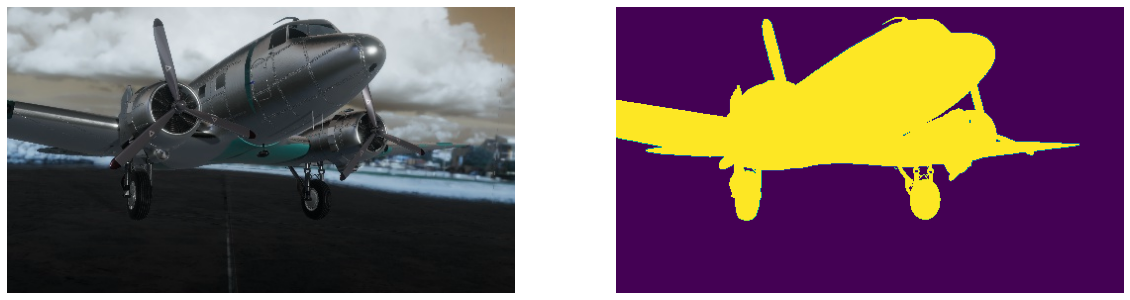

In [ ]:
# segementation as target
#plt.imshow(seg_img.astype(np.float))
target_img = seg_img[:,:,0]

f, (img, seg) = plt.subplots(1, 2, figsize=(20,20))
img.axis('off')
img.imshow(org_img)
seg.axis('off')
seg.imshow(target_img)
plt.show()

In [ ]:
## convert target image to tensor (on gpu)

target_img = cv2.resize(target_img, (round(256*1280/720), 256 ))
tg_seg  = torch.tensor(target_img, dtype=torch.float32).cuda()

## 4.Optimization to match target images

In [ ]:
# 1. initial pose closed to target img
cp = [-10.0, -2.0, 15.0]
lk = [1.0, -1.0,  1.0]
u = [.0, 1.0, 0.0]


cam_pose =  torch.tensor(cp, device= pyredner.get_device(),  requires_grad=True )
lookat = torch.tensor(lk, device= pyredner.get_device(), requires_grad=True)
up = torch.tensor(u, device= pyredner.get_device(), requires_grad=True)

In [ ]:
def model_cam(cam_pose, cam_lookat, up, cam_to_world=None):
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    cam.position = cam_pose
    cam.look_at = cam_lookat
    cam.up = up #torch.tensor([.0, 1.0, 0.0])  # airplane z axis point upwards
    cam.cam_to_world = cam_to_world
    cam.resolution = (256, 455)
    cam.fov = torch.tensor([60.0])


    scene_args = pyredner.RenderFunction.serialize_scene(scene = scene, num_samples = 16, max_bounces = 0, channels = [redner.channels.depth, redner.channels.shading_normal])
    
    # Render the scene as our target image.
    render = pyredner.RenderFunction.apply
    # Render. The first argument is the seed for RNG in the renderer.
    img = render(0, *scene_args)
    return img

In [ ]:
init_img  = model_cam(cam_pose, lookat, up) 

init_depth = init_img[:, :, 0]
init_normal = init_img[:, :, 1:4]

In [ ]:
print(torch.unique(init_depth))
print(np.unique(tg_seg.data.cpu()))
print(type(init_depth))
print(tg_seg.shape)

#np_init_depth = tg_seg.data.cpu()
#init_depth[init_depth > 0] = 1.0
#init_seg =   torch.where(init_depth.double()>0.0, 1.0, init_depth.double())  ## where is not differentiable

# tanh func where x > 2.7 , output --> 1
init_seg = torch.tanh( init_depth * 20 ) # scalr value to make element values appoximate to 0  or  1, 

plt.imshow(init_seg.data.cpu())
print(torch.unique(init_seg))

In [ ]:
# visualization difference
import matplotlib.pyplot as plt

im_diff = np.abs( tg_seg.data.cpu() -  init_seg.data.cpu() )
#torch.abs(tg_edge[0].permute(1,2,0)  - init_edge[0].permute(1,2,0)).data.cpu()


f, (tg_e, init_e, diff_e) = plt.subplots(1,3, figsize= (20,20))
tg_e.imshow(tg_seg.data.cpu())
init_e.imshow(init_seg.data.cpu())
diff_e.imshow(im_diff)
plt.show()

In [ ]:
import torch.nn as nn
 ## optimization
#cam_optimizer = torch.optim.Adam([cam_pose, lookat], lr=0.05)
cam_optimizer = torch.optim.Adam([cam_to_world], lr=0.05)
# Setup plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time
plt.figure()
imgs, losses = [], []
# Run 80 Adam iterations
num_iters = 300

seg_imgs = []
subdir = 'airplane_seg'

loss_f = nn.BCELoss()

for t in range(num_iters):
    cam_optimizer.zero_grad()
    cam.position = cam_pose
    cam.lookat = lookat
    cam.up = up 

    scene_args = pyredner.RenderFunction.serialize_scene(\
        scene = scene,
        num_samples = 4, # We use less samples in the Adam loop.
        max_bounces = 0,
        channels = [redner.channels.depth, redner.channels.shading_normal])
    # Important to use a different seed every iteration, otherwise the result
    # would be biased.
    img = render(t+1, *scene_args)    
    # Compute the loss function. Here it is L2.
    # Both img and target are in linear color space, so no gamma correction is needed.

    img = render(t+1, *scene_args)
    depth = img[:, :, 0]
    normal = img[:, :, 1:4]

    ## seg 
    seg =  torch.tanh( depth * 20 )
    

    print("compute loss==========")
    #Save the images.

    # pyredner.imwrite(depth.cpu(),
    #     'results/test_g_buffer/{}/iter_depth_{}.png'.format(subdir,t),
    #     normalize = True)
    # pyredner.imwrite(normal.cpu(),
    #     'results/test_g_buffer/{}/iter_normal_{}.png'.format(subdir,t),
    #     normalize = True)
    
    # pyredner.imwrite(torch.abs(target_depth - depth).data.cpu(),
    # 'results/test_g_buffer/{}/iter_difference_{}.png'.format(subdir,t),
    # normalize = True)

    n = depth.shape[0]*depth.shape[1]
    #loss = (seg - tg_seg).pow(2).sum()/n  #-  (seg - tg_seg).sum().pow(2)/(n*n)
    
    ## loss = nn.BCELoss()
    loss = loss_f(seg,tg_seg)
 
    ## KL loss:
    #loss = torch.nn.functional.kl_div(edge, tg_edge)

    print('loss:', loss.item())
    # Backpropagate the gradients.
    loss.backward()
    # Take a gradient descent step.
    cam_optimizer.step()
    # cam_loc_optimizer.step()
    # cam_lookat_optimizer.step()

    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2, figsize = (20,10))
    losses.append(loss.data.item())

    
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()

    im_diff = np.abs( tg_seg.data.cpu() -  seg.data.cpu() )
    ax_img.axis('off')
    ax_img.imshow(im_diff)
    plt.show()

    print("cam pose====", cam_pose)
    print("cam lookat===", lookat)


## save images as video

In [ ]:
# Convert the intermediate renderings to a video.
from subprocess import call

In [ ]:
call(["ffmpeg", "-framerate", "24", "-i",
    "results/test_g_buffer/{}/iter_depth_%d.png".format(subdir), "-vb", "20M",
    "results/test_g_buffer/{}/out_depth.mp4".format(subdir)])


In [ ]:
call(["ffmpeg", "-framerate", "24", "-i",
    "results/test_g_buffer/{}/iter_normal_%d.png".format(subdir), "-vb", "30M",
    "results/test_g_buffer/{}/out_normal.mp4".format(subdir)])

In [ ]:
call(["ffmpeg", "-framerate", "24", "-i",
    "results/test_g_buffer/{}/iter_difference_%d.png".format(subdir), "-vb", "30M",
    "results/test_g_buffer/{}/out_difference.mp4".format(subdir)])